In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

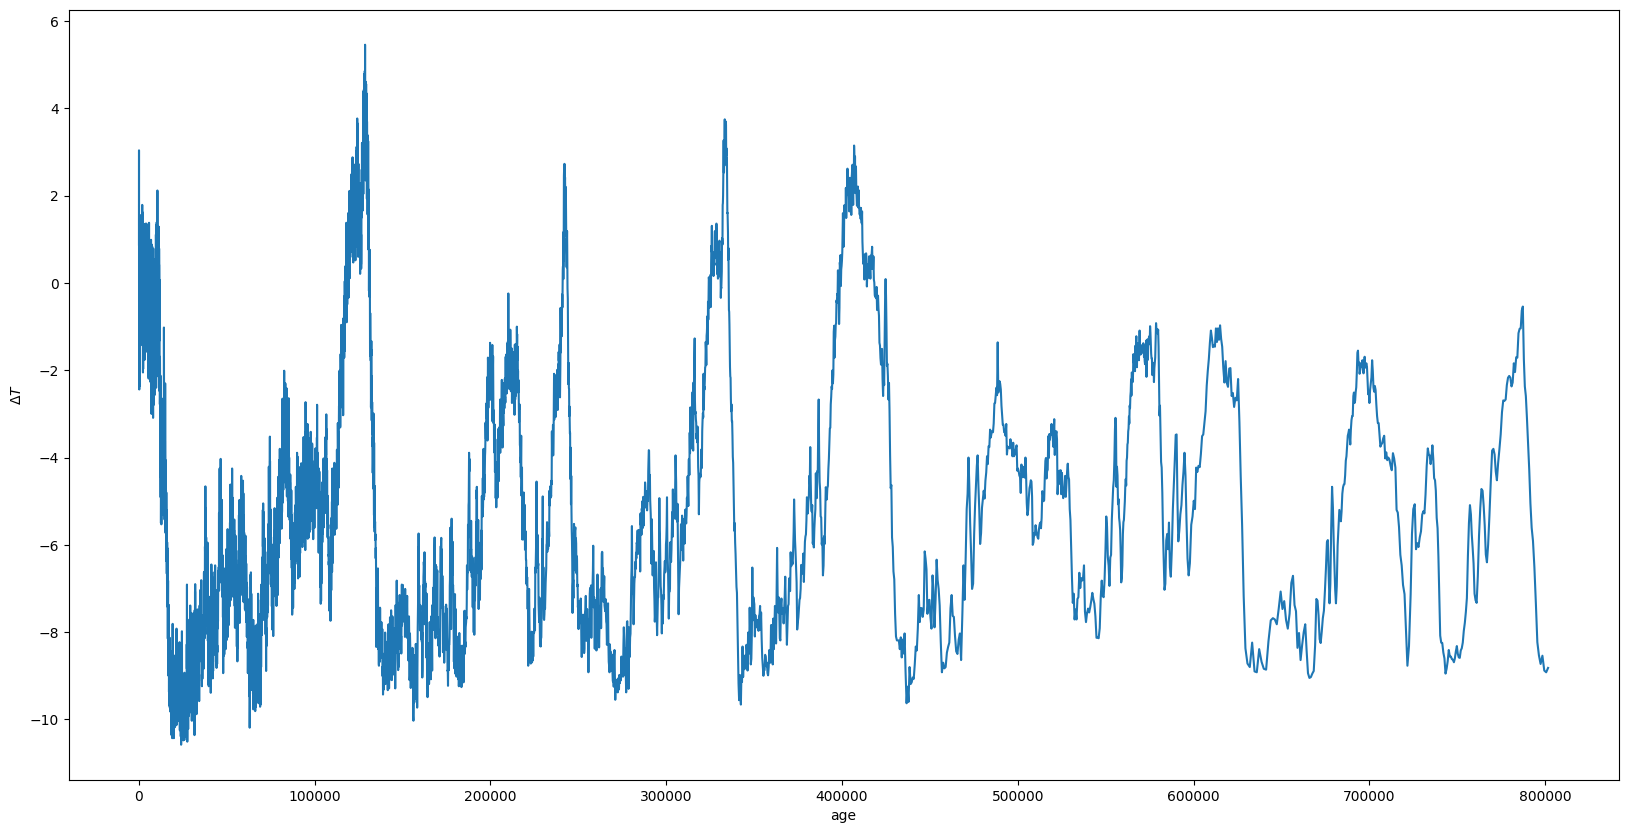

In [2]:
ice_data = np.loadtxt('ice_core_data.txt')
ice_data = np.transpose(ice_data)
age = ice_data[2]
T = ice_data[4]
plt.plot(age,T)
plt.xlabel('age')
plt.ylabel(r'$\Delta T$')
plt.show()

In [3]:
# The Model Function
def model(theta,age=age):
    a1,a2,a3,p1,p2,p3,T0 = theta
    return a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3) + T0


# The Inlike Function, return a number corresponding to how good a fit your model is to your data for a given set of parameters,
# weighted by the error in your data points (i.e. it is more important the fit be close to data points with small error bars 
# than points with large error bars)
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)


# Bounds for the Priors
def lnprior(theta):
    a1, a2, a3, p1, p2, p3, T0 = theta
    if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
        return 0.0
    return -np.inf


# This function combines the steps above by running the lnprior function, 
# and if the function returned -np.inf, passing that through as a return, and if not (if all priors are good), 
# returning the lnlike for that model (by convention we say it's the lnprior output + lnlike output, 
# since lnprior's output should be zero if the priors are good).
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


In [8]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 128
niter = 500
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [9]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


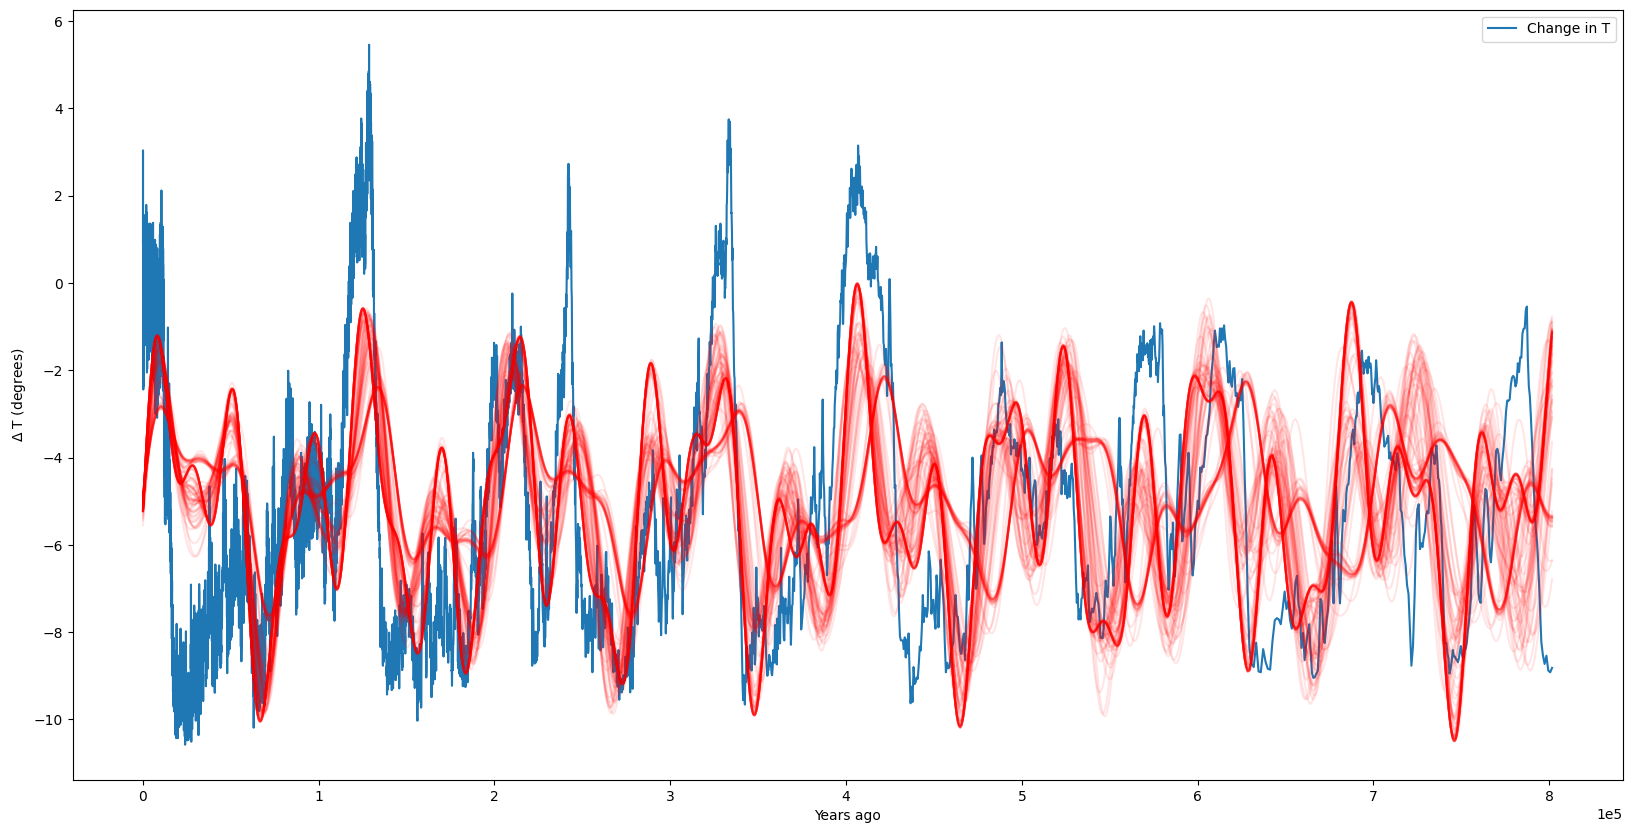

In [16]:
def plotter(sampler,age=age,T=T):
    plt.ion()
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(age, model(theta, age), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

#sampler= main(p0)
plotter(sampler)

In [17]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 1.32757334e+00,  2.08040749e+00,  1.89497710e+00,  2.35221605e+04,
        3.97322482e+04,  9.61377330e+04, -5.25720033e+00])

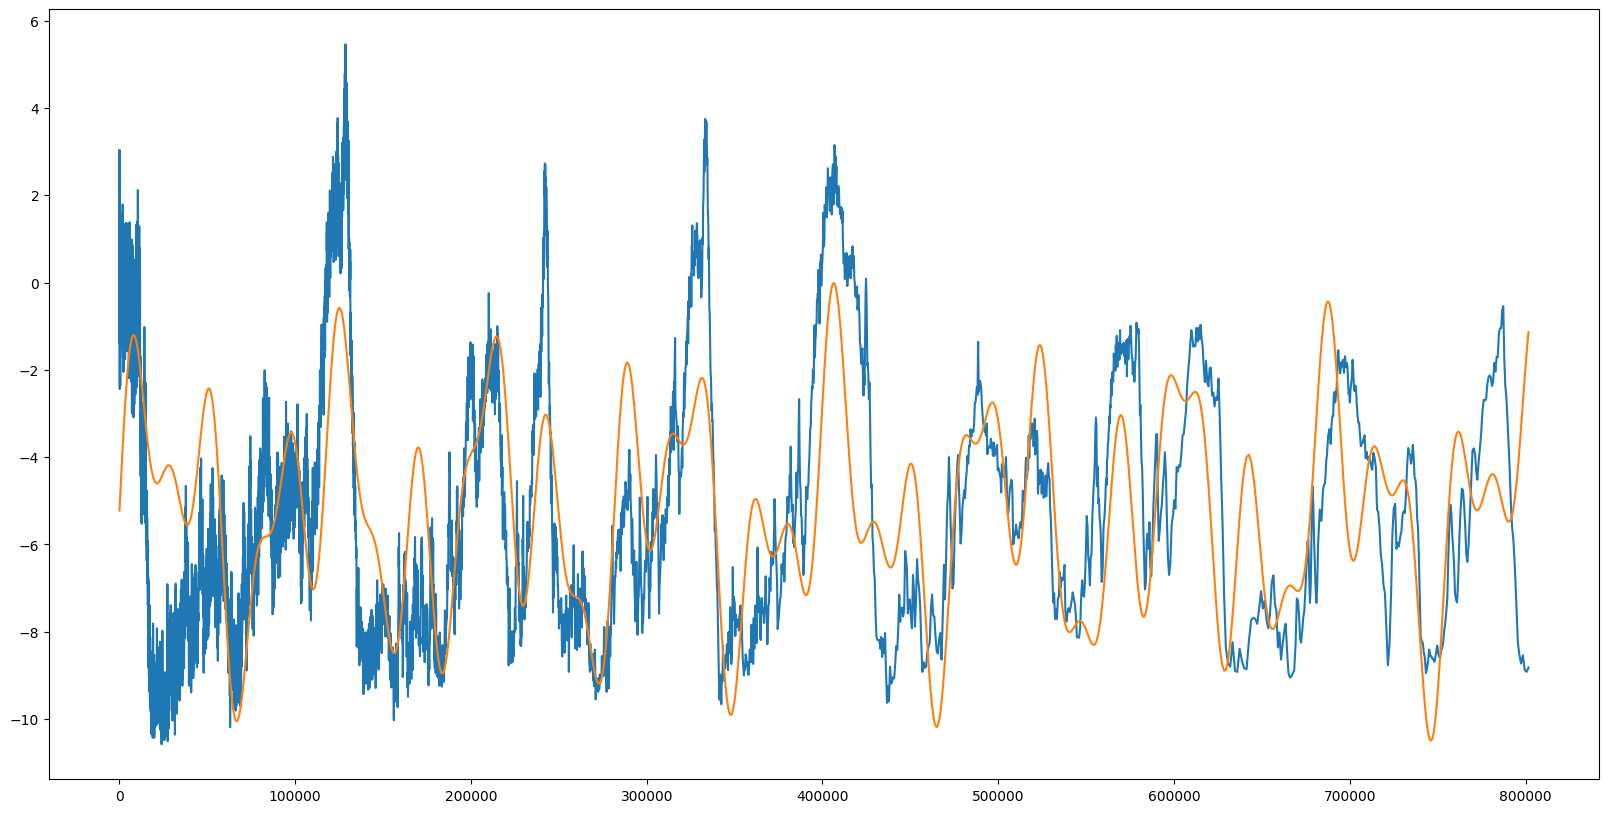

Theta max:  [ 1.32757334e+00  2.08040749e+00  1.89497710e+00  2.35221605e+04
  3.97322482e+04  9.61377330e+04 -5.25720033e+00]


In [19]:
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,best_fit_model,label='Highest Likelihood Model')
plt.show()
print ('Theta max: ',theta_max)

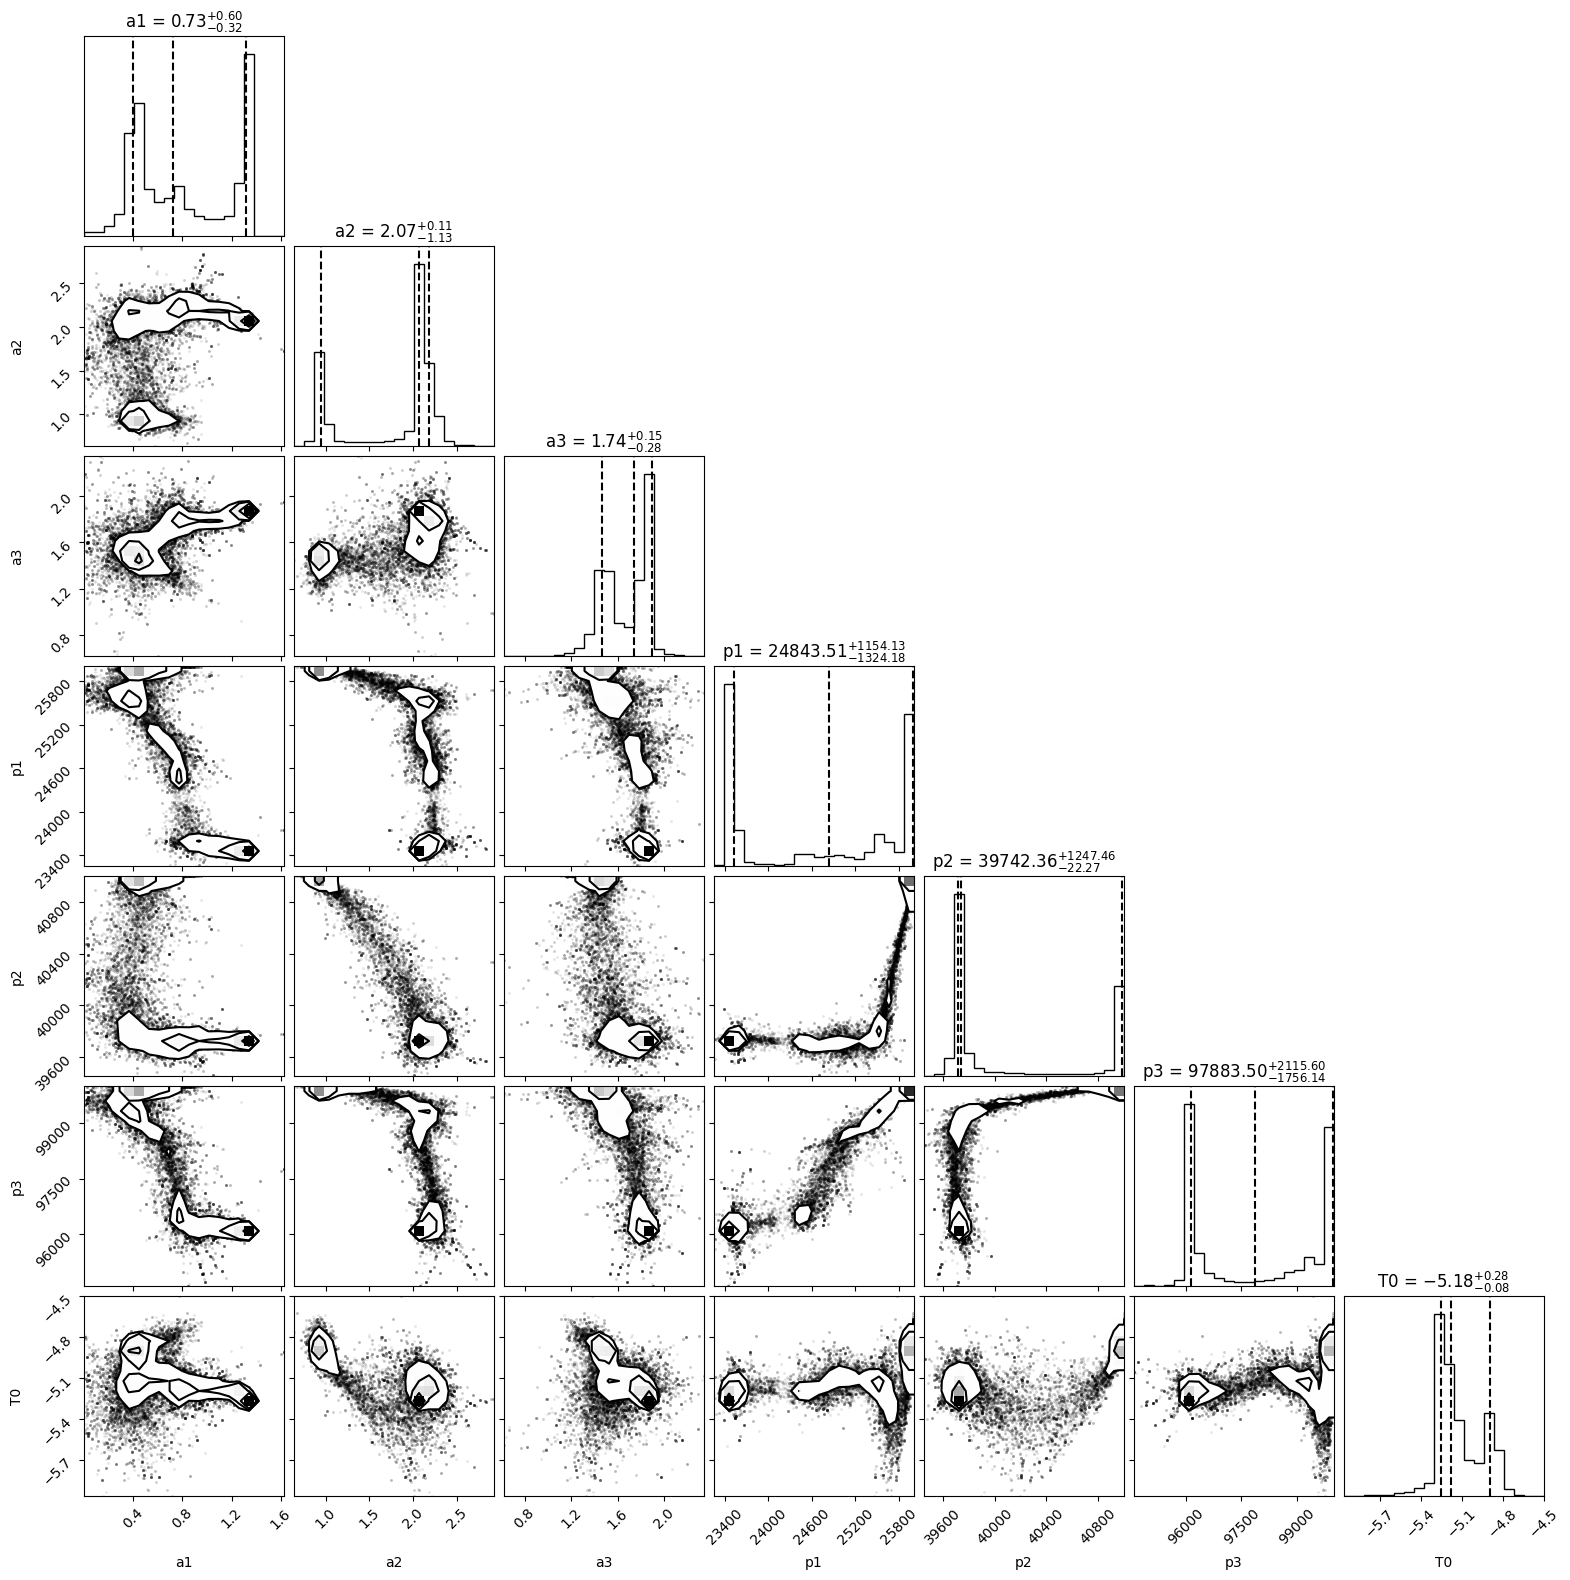

In [20]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])